# Part 1 : Read Fiji NWP Data
To read data from WRF is quite different than GFS, you can use xarray directly to read the data but it will give you direct output of the model with coordinates originally from WRF (sigma level). To make it easier we will use wrf-python module. if you havent installed it you can do:<br>
<code>pip install wrf-python

## Read one file at a time

In [13]:
import wrf
from netCDF4 import Dataset
from wrf import getvar, interplevel, to_np, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim
import os

In [24]:
file_path = 'D:/Projects/fiji-training-2024/data/wrf/'
filename = "wrfout_d02_2024-06-24_00_00_00"

get the diagnostic variable using getvar, for full list of the variable you can refer to this resource:<br>
<a href='https://wrf-python.readthedocs.io/en/latest/diagnostics.html#diagnostic-table'> Table of Available Diagnostics </a>

In [35]:
ncfile = Dataset(os.path.join(file_path,filename))
slp = getvar(ncfile,'slp')
slp

<xarray.DataArray 'slp' (south_north: 402, west_east: 369)>
array([[1016.5263 , 1016.5218 , 1016.519  , ..., 1020.6636 , 1020.66724,
        1020.67065],
       [1016.5132 , 1016.50885, 1016.5059 , ..., 1020.6389 , 1020.6423 ,
        1020.64496],
       [1016.50385, 1016.4985 , 1016.49585, ..., 1020.61554, 1020.618  ,
        1020.621  ],
       ...,
       [1012.9518 , 1012.95215, 1012.9541 , ..., 1013.07715, 1013.0765 ,
        1013.0761 ],
       [1012.94055, 1012.9415 , 1012.9433 , ..., 1013.061  , 1013.06036,
        1013.0603 ],
       [1012.93054, 1012.93207, 1012.9343 , ..., 1013.0451 , 1013.0448 ,
        1013.0451 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 173.9 174.0 ... -175.9 -175.9
    XLAT     (south_north, west_east) float32 -22.32 -22.32 ... -11.75 -11.75
    XTIME    float32 0.0
    Time     datetime64[ns] 2024-06-24
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    description:  sea level pressure
    units:        hPa
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   Mercator(stand_lon=-164.9530029296875, moad_cen_lat=-12.105...

In [36]:
slp['Time']

<xarray.DataArray 'Time' ()>
array('2024-06-24T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    XTIME    float32 0.0
    Time     datetime64[ns] 2024-06-24

In [39]:
# to see the model resolution
slp['XLAT'][1][0]-slp['XLAT'][0][0]

<xarray.DataArray 'XLAT' ()>
array(0.02552795, dtype=float32)
Coordinates:
    XLONG    float32 173.9
    XTIME    float32 0.0
    Time     datetime64[ns] 2024-06-24

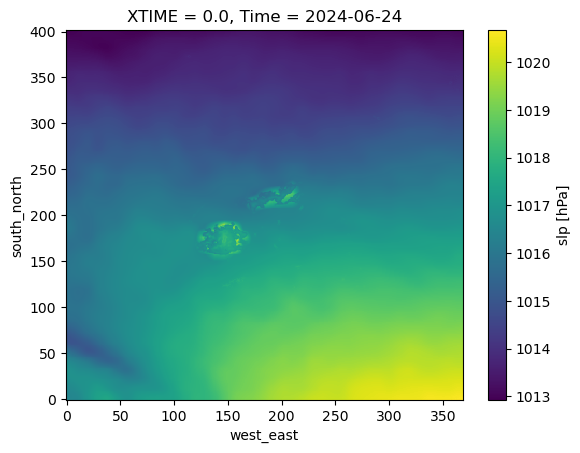

In [37]:
slp.plot()

## Open all files
Open all files in the directory and append it to one data in a time index

In [40]:
file_path = 'D:/Projects/fiji-training-2024/data/wrf/'

In [42]:
ncfiles = [Dataset(f"{file_path}{filename}") for filename in os.listdir(file_path)]
ncfiles

[<class 'netCDF4._netCDF4.Dataset'>
 root group (NETCDF4 data model, file format HDF5):
     TITLE:  OUTPUT FROM WRF V4.4.1 MODEL
     START_DATE: 2024-06-24_00:00:00
     SIMULATION_START_DATE: 2024-06-24_00:00:00
     WEST-EAST_GRID_DIMENSION: 370
     SOUTH-NORTH_GRID_DIMENSION: 403
     BOTTOM-TOP_GRID_DIMENSION: 45
     DX: 3000.0
     DY: 3000.0
     AERCU_OPT: 0
     AERCU_FCT: 1.0
     IDEAL_CASE: 0
     DIFF_6TH_SLOPEOPT: 0
     AUTO_LEVELS_OPT: 2
     DIFF_6TH_THRESH: 0.1
     DZBOT: 50.0
     DZSTRETCH_S: 1.1
     DZSTRETCH_U: 1.1
     SKEBS_ON: 0
     USE_Q_DIABATIC: 0
     GRIDTYPE: C
     DIFF_OPT: 2
     KM_OPT: 4
     DAMP_OPT: 3
     DAMPCOEF: 0.2
     KHDIF: 0.0
     KVDIF: 0.0
     MP_PHYSICS: 6
     RA_LW_PHYSICS: 4
     RA_SW_PHYSICS: 4
     SF_SFCLAY_PHYSICS: 91
     SF_SURFACE_PHYSICS: 2
     BL_PBL_PHYSICS: 1
     CU_PHYSICS: 16
     SF_LAKE_PHYSICS: 0
     SURFACE_INPUT_SOURCE: 3
     SST_UPDATE: 0
     GHG_INPUT: 1
     GRID_FDDA: 0
     GFDDA_INTERVAL_M: 0
  

In [43]:
# Extract the 'slp' variable for all times
slp = getvar(ncfiles, "slp", timeidx=wrf.ALL_TIMES, method="cat")

In [44]:
slp

<xarray.DataArray 'slp' (Time: 25, south_north: 402, west_east: 369)>
array([[[1016.5263 , 1016.5218 , 1016.519  , ..., 1020.6636 ,
         1020.66724, 1020.67065],
        [1016.5132 , 1016.50885, 1016.5059 , ..., 1020.6389 ,
         1020.6423 , 1020.64496],
        [1016.50385, 1016.4985 , 1016.49585, ..., 1020.61554,
         1020.618  , 1020.621  ],
        ...,
        [1012.9518 , 1012.95215, 1012.9541 , ..., 1013.07715,
         1013.0765 , 1013.0761 ],
        [1012.94055, 1012.9415 , 1012.9433 , ..., 1013.061  ,
         1013.06036, 1013.0603 ],
        [1012.93054, 1012.93207, 1012.9343 , ..., 1013.0451 ,
         1013.0448 , 1013.0451 ]],

       [[1016.3994 , 1016.36273, 1016.38104, ..., 1019.8732 ,
         1019.879  , 1019.8788 ],
        [1016.3687 , 1016.31354, 1016.3509 , ..., 1019.85114,
         1019.86206, 1019.8694 ],
        [1016.3058 , 1016.29987, 1016.28143, ..., 1019.84595,
         1019.824  , 1019.8592 ],
...
        [1014.29846, 1014.30896, 1014.3108 , ..., 1014.8512 ,
         1014.85736, 1014.8396 ],
        [1014.28204, 1014.3038 , 1014.2956 , ..., 1014.8362 ,
         1014.84076, 1014.82477],
        [1014.2667 , 1014.2411 , 1014.27203, ..., 1014.80176,
         1014.835  , 1014.8117 ]],

       [[1019.18054, 1019.18945, 1019.19604, ..., 1020.3419 ,
         1020.34125, 1020.3773 ],
        [1019.1487 , 1019.1645 , 1019.1764 , ..., 1020.3385 ,
         1020.3439 , 1020.3449 ],
        [1019.1728 , 1019.1629 , 1019.1396 , ..., 1020.3309 ,
         1020.3357 , 1020.3389 ],
        ...,
        [1013.5066 , 1013.48755, 1013.487  , ..., 1013.6459 ,
         1013.6394 , 1013.64136],
        [1013.47076, 1013.4737 , 1013.4704 , ..., 1013.632  ,
         1013.637  , 1013.5992 ],
        [1013.45   , 1013.4542 , 1013.4555 , ..., 1013.62994,
         1013.5918 , 1013.5861 ]]], dtype=float32)
Coordinates:
    XLONG     (south_north, west_east) float32 173.9 174.0 ... -175.9 -175.9
    XLAT      (south_north, west_east) float32 -22.32 -22.32 ... -11.75 -11.75
    XTIME     (Time) float64 0.0 60.0 120.0 180.0 ... 1.32e+03 1.38e+03 1.44e+03
  * Time      (Time) datetime64[ns] 2024-06-24 ... 2024-06-25
    datetime  (Time) datetime64[ns] 2024-06-24 ... 2024-06-25
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    description:  sea level pressure
    units:        hPa
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   Mercator(stand_lon=-164.9530029296875, moad_cen_lat=-12.105...

See that "TIME" value is having 25 values.

<xarray.Dataset>
Dimensions:                (Time: 1, south_north: 402, west_east: 369,
                            bottom_top: 44, bottom_top_stag: 45,
                            soil_layers_stag: 4, west_east_stag: 370,
                            south_north_stag: 403, seed_dim_stag: 33)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 -22.32 ... ...
    XLONG                  (Time, south_north, west_east) float32 173.9 ... -...
    XTIME                  (Time) datetime64[ns] 2024-06-24T01:00:00
    XLAT_U                 (Time, south_north, west_east_stag) float32 -22.32...
    XLONG_U                (Time, south_north, west_east_stag) float32 173.9 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 -22.33...
    XLONG_V                (Time, south_north_stag, west_east) float32 173.9 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/202)
    Times                  (Time) |S19 b'2024-06-24_01:00:00'
    LU_INDEX               (Time, south_north, west_east) float32 17.0 ... 17.0
    ZNU                    (Time, bottom_top) float32 0.9969 0.9904 ... 0.004424
    ZNW                    (Time, bottom_top_stag) float32 1.0 0.9938 ... 0.0
    ZS                     (Time, soil_layers_stag) float32 0.05 0.25 0.7 1.5
    DZS                    (Time, soil_layers_stag) float32 0.1 0.3 0.6 1.0
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 0.0 ... 0.0
    PC                     (Time, south_north, west_east) float32 0.0 ... 0.0
    LANDMASK               (Time, south_north, west_east) float32 0.0 ... 0.0
    LAKEMASK               (Time, south_north, west_east) float32 0.0 ... 0.0
    SST                    (Time, south_north, west_east) float32 296.9 ... 3...
    SST_INPUT              (Time, south_north, west_east) float32 0.0 ... 0.0
Attributes: (12/134)
    TITLE:                            OUTPUT FROM WRF V4.4.1 MODEL
    START_DATE:                      2024-06-24_00:00:00
    SIMULATION_START_DATE:           2024-06-24_00:00:00
    WEST-EAST_GRID_DIMENSION:        370
    SOUTH-NORTH_GRID_DIMENSION:      403
    BOTTOM-TOP_GRID_DIMENSION:       45
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [4]:
slp

<xarray.DataArray 'slp' (south_north: 402, west_east: 369)>
array([[1016.3994 , 1016.36273, 1016.38104, ..., 1019.8732 , 1019.879  ,
        1019.8788 ],
       [1016.3687 , 1016.31354, 1016.3509 , ..., 1019.85114, 1019.86206,
        1019.8694 ],
       [1016.3058 , 1016.29987, 1016.28143, ..., 1019.84595, 1019.824  ,
        1019.8592 ],
       ...,
       [1012.51184, 1012.51263, 1012.5198 , ..., 1012.50354, 1012.4956 ,
        1012.5374 ],
       [1012.4786 , 1012.51764, 1012.5171 , ..., 1012.50446, 1012.5276 ,
        1012.51587],
       [1012.50323, 1012.5086 , 1012.4854 , ..., 1012.524  , 1012.5211 ,
        1012.5227 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 173.9 174.0 ... -175.9 -175.9
    XLAT     (south_north, west_east) float32 -22.32 -22.32 ... -11.75 -11.75
    XTIME    float32 60.0
    Time     datetime64[ns] 2024-06-24T01:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    description:  sea level pressure
    units:        hPa
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   Mercator(stand_lon=-164.9530029296875, moad_cen_lat=-12.105...

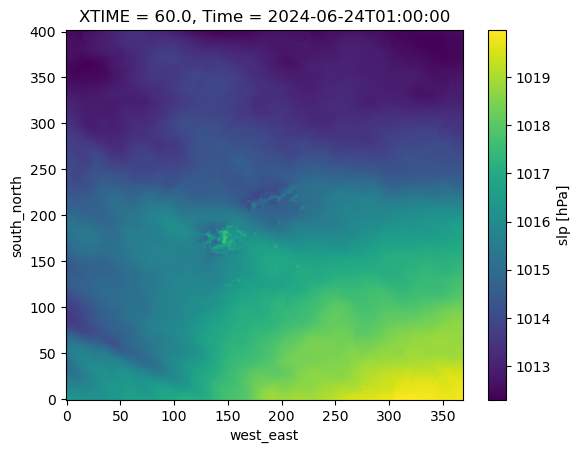

In [5]:
slp.plot()

In [6]:
print(slp)

<xarray.DataArray 'slp' (south_north: 402, west_east: 369)>
array([[1016.3994 , 1016.36273, 1016.38104, ..., 1019.8732 , 1019.879  ,
        1019.8788 ],
       [1016.3687 , 1016.31354, 1016.3509 , ..., 1019.85114, 1019.86206,
        1019.8694 ],
       [1016.3058 , 1016.29987, 1016.28143, ..., 1019.84595, 1019.824  ,
        1019.8592 ],
       ...,
       [1012.51184, 1012.51263, 1012.5198 , ..., 1012.50354, 1012.4956 ,
        1012.5374 ],
       [1012.4786 , 1012.51764, 1012.5171 , ..., 1012.50446, 1012.5276 ,
        1012.51587],
       [1012.50323, 1012.5086 , 1012.4854 , ..., 1012.524  , 1012.5211 ,
        1012.5227 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 173.9 174.0 ... -175.9 -175.9
    XLAT     (south_north, west_east) float32 -22.32 -22.32 ... -11.75 -11.75
    XTIME    float32 60.0
    Time     datetime64[ns] 2024-06-24T01:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  